In [ ]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

from prophet import Prophet

try:
  from google.colab import files
  from google.colab import drive
  uploaded = files.upload()
  !mkdir -p "/content/drive/My Drive/p9"
  drive.mount('/content/drive')
  IN_COLAB = True
except:
  IN_COLAB = False
import warnings
warnings.filterwarnings('once')

Initialize time series

In [2]:
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv' if not IN_COLAB else 'ConsumptionIndustry.csv', sep=';')

df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

Functions

In [7]:
def plot_data(data_train, data_test, predictions, save_at=''):
  plt.figure(figsize=(7, 3))
  plt.plot(data_train.index, data_train, label=f'Train ({data_train.index[0]} - {data_train.index[-1]})')
  plt.plot(data_test.index, data_test, label=f'Test ({data_test.index[0]} - {data_test.index[-1]})')
  plt.plot(data_test.index, predictions, label='Prediction')
  plt.title('Consumption in danish private households with prediction')
  plt.xlabel('Measurements')
  plt.ylabel('Power (kW / charger)')
  plt.legend()
  if save_at:
    plt.savefig(save_at)
  plt.show()

def sample_data_with_train_window(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name):
  model_res = model.fit()

  if "SARIMA" in model_name and "STL" not in model_name:
    return model_res.get_forecast(steps=forecast_horizon).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)

def create_result_table(results, columns=[]):
  result_table = pd.DataFrame(results)
  result_table.columns = columns
  result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)
  return result_table


Optimize functions

In [10]:
def optimize_SARIMAX(data_train, data_test, forecast_horizon, model_name):
  results = []
  best_rmse = 0
  p = d = q = range(0, 3)
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
      try:
          model = SARIMAX(data_train, order=param, seasonal_order=seasonal_param)
          predictions = forecast_whitebox_model(model, forecast_horizon, model_name)
      except:
          continue
      
      rmse = root_mean_squared_error(data_test, predictions)
      results.append([f"{param}x{seasonal_param}", rmse])
      print(f"{param}x{seasonal_param} - RMSE: {rmse}")

      if rmse < best_rmse or best_rmse == 0:
        best_prediction = predictions

  result_table = create_result_table(results, columns=['params', 'rmse'])
  return result_table, best_prediction

def optimize_Theta_model(data_train, data_test, forecast_horizon, model_name):
  results = []
  best_rmse = 0
  p = range(1, 25)
  d = [True, False]
  u = [True, False]
  m = ['additive', 'multiplicative']
  di = [True, False]

  for param in itertools.product(p, d, u, m, di):
    try:
      model = ThetaModel(data_train, period=param[0], deseasonalize=param[1], use_test=param[2], method=param[3], difference=param[4])
    except:
      continue

    predictions = forecast_whitebox_model(model, forecast_horizon, model_name)
    rmse = root_mean_squared_error(data_test, predictions)
    results.append([param, rmse])
    print(f"{param} - RMSE: {rmse}")
    
    if rmse < best_rmse or best_rmse == 0:
      best_prediction = predictions

  result_table = create_result_table(results, columns=['params', 'rmse'])
  return result_table, best_prediction

Optimizing through whole dataset

(1, True, True, 'additive', True) - RMSE: 8983.592065618404
(1, True, True, 'additive', False) - RMSE: 8983.592065618404
(1, True, True, 'multiplicative', True) - RMSE: 8983.592065618404
(1, True, True, 'multiplicative', False) - RMSE: 8983.592065618404
(1, True, False, 'additive', True) - RMSE: 8983.592065618404
(1, True, False, 'additive', False) - RMSE: 8983.592065618404
(1, True, False, 'multiplicative', True) - RMSE: 8983.592065618404
(1, True, False, 'multiplicative', False) - RMSE: 8983.592065618404
(1, False, True, 'additive', True) - RMSE: 8983.592065618404
(1, False, True, 'additive', False) - RMSE: 8983.592065618404
(1, False, True, 'multiplicative', True) - RMSE: 8983.592065618404
(1, False, True, 'multiplicative', False) - RMSE: 8983.592065618404
(1, False, False, 'additive', True) - RMSE: 8983.592065618404
(1, False, False, 'additive', False) - RMSE: 8983.592065618404
(1, False, False, 'multiplicative', True) - RMSE: 8983.592065618404
(1, False, False, 'multiplicative', F

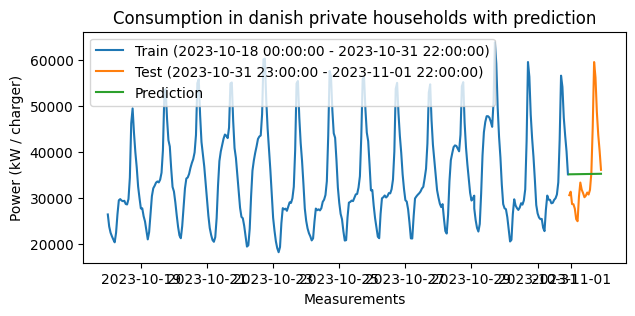

In [12]:
model_name = 'ThetaModel'
date_start = '2023-11-01'
window_train_size = 24*30*2 #hours
forecast_horizon = 24*7*2 #hours
data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)

warnings.filterwarnings("ignore")
result, pred = optimize_Theta_model(data_train, data_test, forecast_horizon, model_name)
warnings.filterwarnings("default")


if IN_COLAB:
  plot_data(data_train, data_test, pred, save_at=f'/content/drive/My Drive/p9/{window_train_size}_{forecast_horizon}_{model_name}.png')
  result.to_csv(f'/content/drive/My Drive/p9/{window_train_size}_{forecast_horizon}_{model_name}.csv')
else:
  plot_data(data_train, data_test, pred, save_at=f'../Results/Whitebox/Tuning/{window_train_size}_{forecast_horizon}_{model_name}.png')
  result.to_csv(f'../Results/Whitebox/Tuning/{window_train_size}_{forecast_horizon}_{model_name}.csv')